# **WARNING**

In order for this notebook to run, you must first run the notebook `3_1_generate_ns_win_probability_data.ipynb` and generate the file `result/twoplayer_ns_results/player10_win_probability_results.csv` which contains the optimal policy and value functions for the solved MDPs for different player skill model and epsilon combinatinos. It is also important to make sure that all combinations you want to analyse in this file were generated during this process. 

# 1.0 Notebook Parameters

Please specify the following variables:
1. `project_directory`: your project directory path
2. `epsilon_list`: the list of execution error multiplers (epsilon) that you want to consider in your analysis.

In [1]:

# Change this to the project directory path for your computer  
project_directory = '/Users/rachael/Desktop/darts-thesis'

# Set the epsilons that will be considered in this analysis 
epsilon_list = [1,2,3,4,5,6,7,8,9]


# 2.0 Notebook Setup

Import libraries and run prerequisites.

In [8]:
# Import and configure modules from this project

import os

os.chdir(project_directory)

import function_init_simple_mdp as imdp
import class_handicap as hc

handicap = hc.Handicap(epsilon_list=epsilon_list,results_file_name='result/player10_turn_results.csv')

In [9]:
# Import and configure external modules

import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=300)
np.set_printoptions(threshold=300)

import pandas as pd

# Plotting 
import matplotlib.pyplot as plt
from matplotlib import cm, colors

import seaborn as sns
#sns.set_theme()   # uncomment this if you want seasborn theme

In [10]:
# Helper functions

def color_map_color(value, cmap_name='Wistia', vmin=0, vmax=1):
    # norm = plt.Normalize(vmin, vmax)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = colors.rgb2hex(rgb)
    return color


def linear_interpolation(x1,x2,y1,y2,y):
    x = x1 - ((y1-y)/(y1-y2))*(x1-x2)
    return x 


# 3.0 Load Data

In [12]:
# Load csv
df = pd.read_csv('result/player10_win_probability_results.csv')
df = df[['epsilon_weaker', 'epsilon_stronger', 'score_weaker','score_stronger', 'credits_weaker', 'current_turn',
       'win_probability_weaker']]

In [4]:
df

,epsilon_weaker,epsilon_stronger,score_weaker,score_stronger,credits_weaker,current_turn,win_probability_weaker
0,1,1,2,2,0,weaker,0.680422
1,1,1,2,2,0,stronger,0.319578
2,1,1,2,3,0,weaker,0.704062
3,1,1,2,3,0,stronger,0.369911
4,1,1,2,4,0,weaker,0.589241
...,...,...,...,...,...,...,...
224999995,9,9,501,499,9,stronger,1.000000
224999996,9,9,501,500,9,weaker,1.000000
224999997,9,9,501,500,9,stronger,1.000000
224999998,9,9,501,501,9,weaker,1.000000


# 4. Dynamic Credits Analysis

### 4.1 Handicaps with Win Probability 

#### 4.1.1 Calculate New Optimal Dynamic Credit Handicaps 

Below we calculate the new handicaps that actually equalize win probability and store it in the `handicap_vals` dictionary.

In [173]:
# Get data for when both players are at the start of the game
df_start = df.loc[(df.score_weaker==501) & (df.score_stronger==501)]

# Get data for averaged case across starters 
df_start_avg = df_start.groupby(['epsilon_weaker', 'epsilon_stronger', 'score_weaker','score_stronger', 'credits_weaker']).mean()
df_start_avg = df_start_avg.reset_index()


# Define epsilons that we want to get handicaps for 
epsilon_list = [1,2,3,4,5,6,7,8,9]

# Create a dictionary of win probabilities for different (es,ew,beta) combinations
epsilon_dfs = {}

# Keys are: stronger epsilon (es) --> weaker epsilon (ew) --> list of win probabilities indexed by beta 
# Can get the win probability for a given (es,ew,beta) using epsilon_dfs[es][ew][beta]

for es in epsilon_list:

    epsilon_dfs[es] = {}

    for ew in epsilon_list:

        if ew >= es:
            
            # Get win probability from dataframe
            epsilon_dfs[es][ew] = df_start_avg.loc[(df_start_avg.epsilon_weaker==ew) & (df_start_avg.epsilon_stronger==es)].win_probability_weaker.values.copy()

# Create a dictionary of optimal handicaps that equalize win probability for any (es,ew) combination 
handicap_vals = {}

for es in epsilon_list:

    # Want each player to have a 50% chance of winning, but could change this to desired threshold 
    # Corresponds to p(weaker player wins)
    target_win_probability = 0.5

    handicap_vals[es] = {}

    for ew in epsilon_list:

        if es <= ew:

            beta_vs_probs = epsilon_dfs[es][ew]

            for b in range(1,len(beta_vs_probs)):

                x1 = b-1
                x2 = b 
                y1 = beta_vs_probs[b-1]
                y2 = beta_vs_probs[b]

                if (target_win_probability >= round(y1,10)) & (target_win_probability <= round(y2,10)):
                    
                    # Use horizontal line of target win probability to calculate - see graphs in 1.2 for illustration
                    handicap_val = linear_interpolation(x1,x2,y1,y2,target_win_probability)

                    handicap_vals[es][ew] = abs(handicap_val)



/var/folders/jj/jcq76kp53_zchkx8b5cvhdsh0000gn/T/ipykernel_1026/1724004533.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_start_avg = df_start.groupby(['epsilon_weaker', 'epsilon_stronger', 'score_weaker','score_stronger', 'credits_weaker']).mean()


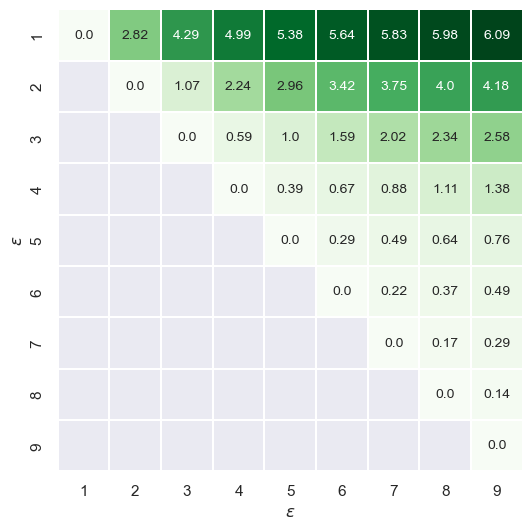

In [175]:
handicap_list = []

for i in range(len(epsilon_list)):

    handicap_sub_list = []

    for j in range(len(epsilon_list)):

        try: 
            handicap_val = handicap_vals[epsilon_list[i]][epsilon_list[j]]
            handicap_sub_list.append(handicap_val)
        except: 
            handicap_sub_list.append(1000)
    
    handicap_list.append(handicap_sub_list)

df_handicap = pd.DataFrame(handicap_list)
df_handicap.index = epsilon_list
df_handicap.columns = epsilon_list
df_handicap = df_handicap.replace(1000,np.nan)
df_handicap = df_handicap.round(2)

fig = sns.set(rc={'figure.figsize':(6,6)})
fig = sns.heatmap(df_handicap,annot=True,annot_kws={"size": 10},fmt="",cmap='Greens',linewidths=0.30,cbar=False)
#fig = plt.title("Difference in expected throws using spot point handicap system")
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')

#### 4.1.2 Evaluate Old Dynamic Credit Handicaps using Win Probability

We also want to examine the win probabilities of the handicaps we previously calculated using expected turns to finish the game. This is calculated and stored in `handicap_win_probs` in the code below.

In [135]:

handicap_win_probs = {}

for es in epsilon_list:

    handicap_win_probs[es] = {}

    for ew in epsilon_list:

        if es <= ew:

            handicap_estimate,_,_,_ = handicap.get_dynamic_credits_handicap(es,ew)

            beta_vs_probs = epsilon_dfs[es][ew]

            for b in range(1,len(beta_vs_probs)):

                x1 = beta_vs_probs[b-1]
                x2 = beta_vs_probs[b]
                y1 = b-1
                y2 = b

                if (handicap_estimate >= y1) & (handicap_estimate <= y2):
                    
                    win_prob = linear_interpolation(x1,x2,y1,y2,handicap_estimate)

                    handicap_win_probs[es][ew] = win_prob

In [141]:
# We see that these are all pretty close to 0.5, but not exact! 

print('Example: win probabilities using previous dynamic credit handicap, stronger player epsilon=1\n')
print(handicap_win_probs[1])

Example: win probabilities using previous dynamic credit handicap, stronger player epsilon=1

{1: 0.5000000000000003, 2: 0.4876856230672054, 3: 0.48707246434837215, 4: 0.48630174242089874, 5: 0.48751029246013067, 6: 0.4890679318971065, 7: 0.4880221775239588, 8: 0.48506918112751995, 9: 0.48224156539645857}


### 4.2 Plotting Dynamic Credits vs. Win Probability

In [15]:
##################################
# PARAMETERS (TO CHNAGE)
##################################

# Epsilon of stronger player
e_stronger = 1

# Epsilon of weaker players for comparison
epsilon_list_master = [1,2,3,4,5,6,7,8,9]


##################################
# PARAMETERS (STATIC)
##################################

# Prune list to values that are weaker than stronger player epsilon
epsilon_list = [e for e in epsilon_list_master if e >= e_stronger] 

# Should not change this, allows colors to be consistent accross all graphs
epsilon_color_list = [1,2,3,4,5,6,7,8,9]

##################################


# Get data for specified stronger player
dfe = df.loc[df.epsilon_stronger==e_stronger]

# Get data for when both players are at the start of the game
df_start = dfe.loc[(dfe.score_weaker==501) & (dfe.score_stronger==501)]

# Get data for when weaker and stronger player are starting, respectively 
df_start_weaker = df_start.loc[df_start.current_turn=='weaker']
df_start_stronger = df_start.loc[df_start.current_turn=='stronger']

# Get data for averaged case across starters 
df_start_avg = df_start.groupby(['epsilon_weaker', 'epsilon_stronger', 'score_weaker','score_stronger', 'credits_weaker']).mean()
df_start_avg = df_start_avg.reset_index()

# Visualize data
# df_start_weaker


/var/folders/jj/jcq76kp53_zchkx8b5cvhdsh0000gn/T/ipykernel_41780/723428470.py:36: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_start_avg = df_start.groupby(['epsilon_weaker', 'epsilon_stronger', 'score_weaker','score_stronger', 'credits_weaker']).mean()


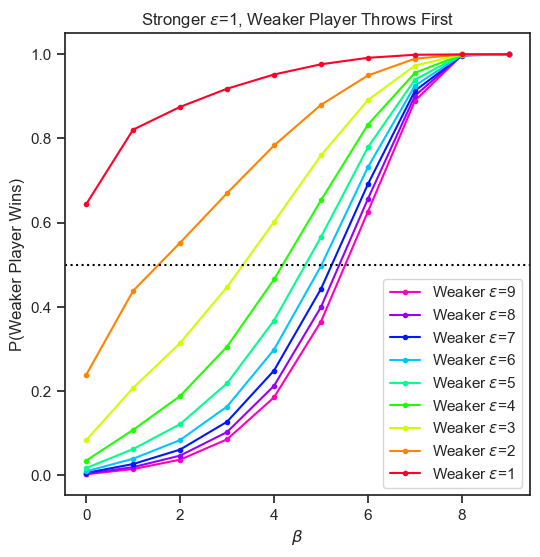

In [145]:

# Housekeeping 
e_leg = [] 
vmax=max(epsilon_color_list)
vmin=min(epsilon_color_list)
fig = sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks")

# Plot each token line 
for e in reversed(range(len(epsilon_list))):

    # Get the epsilon for this index and its color
    epsilon=epsilon_list[e]
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)


    # Get the data for this specific ew (epsilon for the weaker player)
    dfew = df_start_weaker.loc[df_start_weaker.epsilon_weaker==epsilon]
    dfew = dfew[['credits_weaker','win_probability_weaker']]    
    dfew = dfew.set_index('credits_weaker')

    e_leg.append(r'Weaker $\epsilon$={}'.format(epsilon))
    fig = plt.plot(dfew,marker ='.',color=color)

fig = plt.title(fr'Stronger $\epsilon$={epsilon}, Weaker Player Throws First')
fig = plt.xlabel(r'$\beta$')
fig = plt.ylabel(r'P(Weaker Player Wins)')
fig = plt.legend(e_leg)

# Plot horizontal line for equal win probabilities 
fig = plt.axhline(0.5,color='black',linestyle='dotted') 

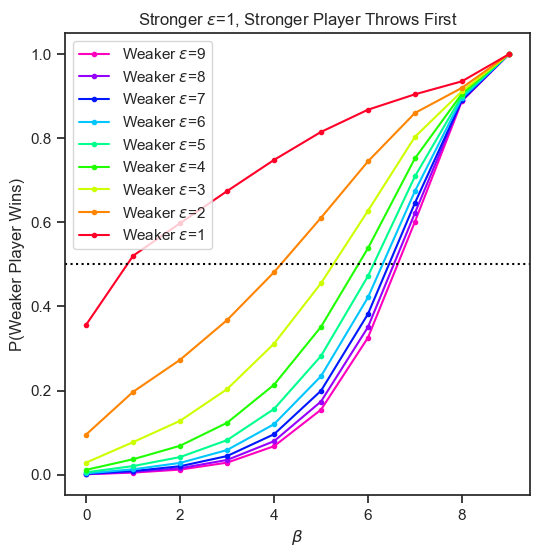

In [146]:


e_leg = []
vmax=max(epsilon_color_list)
vmin=min(epsilon_color_list)

fig = sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks")

# Plot each token line 
for e in reversed(range(len(epsilon_list))):
    epsilon=epsilon_list[e]
    dfew = df_start_stronger.loc[df_start_stronger.epsilon_weaker==epsilon]
    dfew = dfew[['credits_weaker','win_probability_weaker']]    
    dfew = dfew.set_index('credits_weaker')
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    e_leg.append(r'Weaker $\epsilon$={}'.format(epsilon))
    fig = plt.plot(dfew,marker ='.',color=color)

fig = plt.title(fr'Stronger $\epsilon$={epsilon}, Stronger Player Throws First')
fig = plt.xlabel(r'$\beta$')
fig = plt.ylabel(r'P(Weaker Player Wins)')
fig = plt.legend(e_leg)

# Plot horizontal line for equal win probabilities 
fig = plt.axhline(0.5,color='black',linestyle='dotted') 


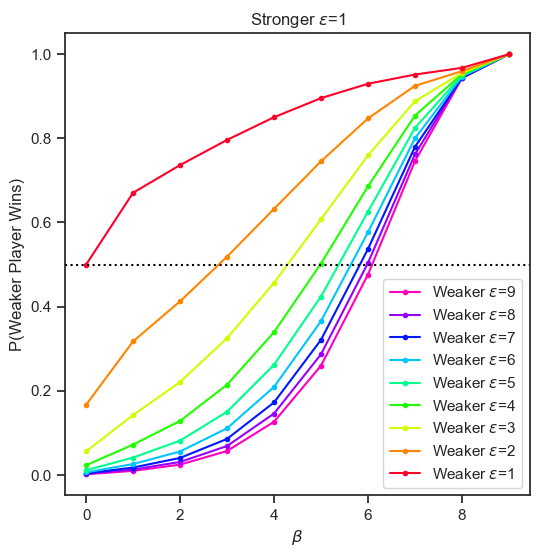

In [147]:


e_leg = []
vmax=max(epsilon_color_list)
vmin=min(epsilon_color_list)

fig = sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks")

# Plot each token line 
for e in reversed(range(len(epsilon_list))):
    epsilon=epsilon_list[e]
    dfew = df_start_avg.loc[df_start_avg.epsilon_weaker==epsilon]
    dfew = dfew[['credits_weaker','win_probability_weaker']]    
    dfew = dfew.set_index('credits_weaker')
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    e_leg.append(r'Weaker $\epsilon$={}'.format(epsilon))
    fig = plt.plot(dfew,marker ='.',color=color)

fig = plt.title(fr'Stronger $\epsilon$={epsilon}')
fig = plt.xlabel(r'$\beta$')
fig = plt.ylabel(r'P(Weaker Player Wins)')
fig = plt.legend(e_leg)

# Plot horizontal line for equal win probabilities 
fig = plt.axhline(0.5,color='black',linestyle='dotted') 


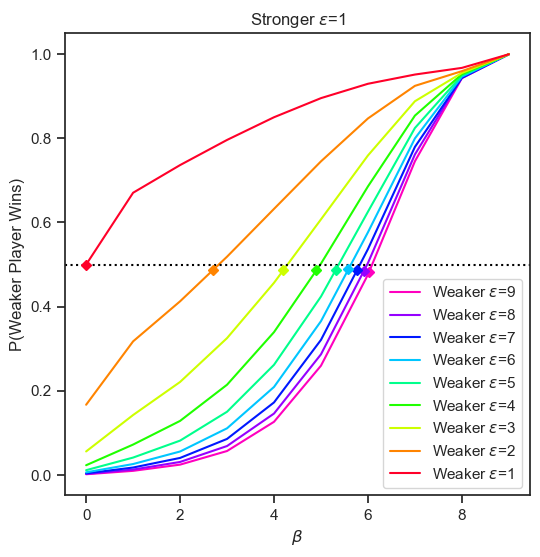

In [189]:

e_leg = []
vmax=max(epsilon_color_list)
vmin=min(epsilon_color_list)

fig = sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks")

# Plot each token line 
for e in reversed(range(len(epsilon_list))):
    epsilon=epsilon_list[e]
    dfew = df_start_avg.loc[df_start_avg.epsilon_weaker==epsilon]
    dfew = dfew[['credits_weaker','win_probability_weaker']]    
    dfew = dfew.set_index('credits_weaker')
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    e_leg.append(r'Weaker $\epsilon$={}'.format(epsilon))
    #fig = plt.plot(dfew,marker ='.',color=color)
    fig = plt.plot(dfew,color=color)


fig = plt.title(fr'Stronger $\epsilon$={epsilon}')
fig = plt.xlabel(r'$\beta$')
fig = plt.ylabel(r'P(Weaker Player Wins)')
fig = plt.legend(e_leg)

# Plot horizontal line for equal win probabilities 
fig = plt.axhline(0.5,color='black',linestyle='dotted') 


for e in reversed(range(len(epsilon_list))):
    epsilon = epsilon_list[e]
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    eh_b,_,_,_ = handicap.get_dynamic_credits_handicap(e_stronger,epsilon)
    eh_b_v = handicap_win_probs[e_stronger][epsilon]
    fig = plt.plot(eh_b, eh_b_v, marker="D", markersize=5, color=color)


### 4.3 Starting Score Sandbox - Plotting Dynamic Credits vs. Win Probability

In [16]:
##################################
# PARAMETERS (TO CHNAGE)
##################################

# Epsilon of stronger player
e_stronger = 1

# Epsilon of weaker players for comparison
epsilon_list_master = [1,2,3,4,5,6,7,8,9]

# Select Starting Score
starting_score = 24

##################################


# Get data for specified stronger player
dfe = df.loc[df.epsilon_stronger==e_stronger]

# Get data for when both players are at the start of the game
df_start_special = dfe.loc[(dfe.score_weaker==starting_score) & (dfe.score_stronger==starting_score)]

# Get data for when weaker and stronger player are starting, respectively 
df_start_weaker_special = df_start_special.loc[df_start_special.current_turn=='weaker']
df_start_stronger_special = df_start_special.loc[df_start_special.current_turn=='stronger']

# Get data for averaged case across starters 
df_start_avg_special = df_start_special.groupby(['epsilon_weaker', 'epsilon_stronger', 'score_weaker','score_stronger', 'credits_weaker']).mean()
df_start_avg_special = df_start_avg_special.reset_index()



/var/folders/jj/jcq76kp53_zchkx8b5cvhdsh0000gn/T/ipykernel_41780/3984427128.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_start_avg_special = df_start_special.groupby(['epsilon_weaker', 'epsilon_stronger', 'score_weaker','score_stronger', 'credits_weaker']).mean()


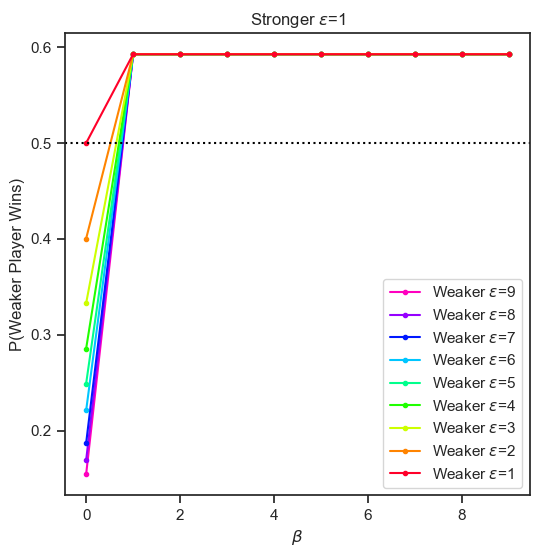

In [18]:


e_leg = []
vmax=max(epsilon_color_list)
vmin=min(epsilon_color_list)

fig = sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks")

# Plot each token line 
for e in reversed(range(len(epsilon_list))):
    epsilon=epsilon_list[e]
    dfew = df_start_avg_special.loc[df_start_avg_special.epsilon_weaker==epsilon]
    dfew = dfew[['credits_weaker','win_probability_weaker']]    
    dfew = dfew.set_index('credits_weaker')
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    e_leg.append(r'Weaker $\epsilon$={}'.format(epsilon))
    fig = plt.plot(dfew,marker ='.',color=color)

fig = plt.title(fr'Stronger $\epsilon$={epsilon}')
fig = plt.xlabel(r'$\beta$')
fig = plt.ylabel(r'P(Weaker Player Wins)')
fig = plt.legend(e_leg)

# Plot horizontal line for equal win probabilities 
fig = plt.axhline(0.5,color='black',linestyle='dotted') 


# 5.0 Head Start

In [62]:
e_stronger = 3

# Get data for specified stronger player
dfe = df.loc[df.epsilon_stronger==e_stronger]

# Get data for when *stronger* player is at start of game and no credits are alotted 
df_headstart = dfe.loc[(dfe.credits_weaker==0) & (dfe.score_stronger==501)]

# Get data for when weaker and stronger player are starting, respectively 
df_headstart_weaker = df_headstart.loc[df_headstart.current_turn=='weaker']
df_headstart_stronger = df_headstart.loc[df_headstart.current_turn=='stronger']
df_headstart_avg = df_headstart.groupby(['epsilon_weaker', 'epsilon_stronger', 'score_weaker', 'score_stronger','credits_weaker']).mean()
df_headstart_avg = df_headstart_avg.reset_index()

# Visualize data
df_headstart_weaker

/var/folders/jj/jcq76kp53_zchkx8b5cvhdsh0000gn/T/ipykernel_1026/3565033725.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_headstart_avg = df_headstart.groupby(['epsilon_weaker', 'epsilon_stronger', 'score_weaker', 'score_stronger','credits_weaker']).mean()


,epsilon_weaker,epsilon_stronger,score_weaker,score_stronger,credits_weaker,current_turn,win_probability_weaker
85000998,3,3,2,501,0,weaker,0.960664
85001998,3,3,3,501,0,weaker,0.935757
85002998,3,3,4,501,0,weaker,0.986991
85003998,3,3,5,501,0,weaker,0.975131
85004998,3,3,6,501,0,weaker,0.978602
...,...,...,...,...,...,...,...
115495998,9,3,497,501,0,weaker,0.113061
115496998,9,3,498,501,0,weaker,0.111982
115497998,9,3,499,501,0,weaker,0.110910
115498998,9,3,500,501,0,weaker,0.109847


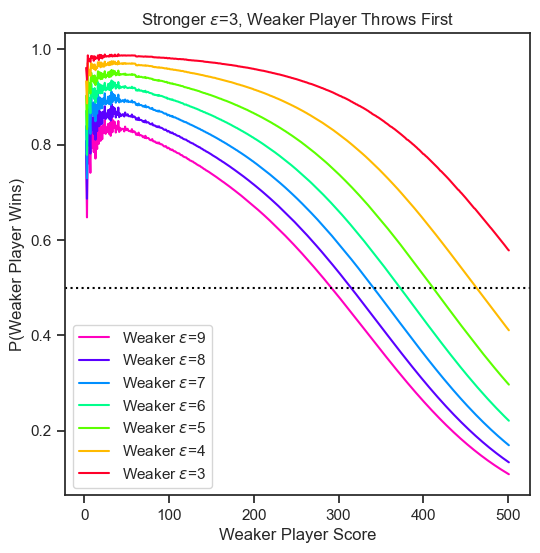

In [63]:
# List of epsilon values
epsilon_list = [1,2,3,4,5,6,7,8,9]
epsilon_list = [3,4,5,6,7,8,9]

# Housekeeping 
e_leg = []
vmax=max(epsilon_list)
vmin=min(epsilon_list)
fig = sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks")

# Plot each token line 
for e in reversed(range(len(epsilon_list))):
    epsilon=epsilon_list[e]
    dfew = df_headstart_weaker.loc[df_headstart_weaker.epsilon_weaker==epsilon]
    dfew = dfew[['score_weaker','win_probability_weaker']]    
    dfew = dfew.set_index('score_weaker')
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    e_leg.append(r'Weaker $\epsilon$={}'.format(epsilon))
    fig = plt.plot(dfew,color=color)

fig = plt.title(fr'Stronger $\epsilon$={epsilon}, Weaker Player Throws First')
fig = plt.xlabel(r'Weaker Player Score')
fig = plt.ylabel(r'P(Weaker Player Wins)')
fig = plt.legend(e_leg)

# Plot horizontal line for equal win probabilities 
fig = plt.axhline(0.5,color='black',linestyle='dotted') 

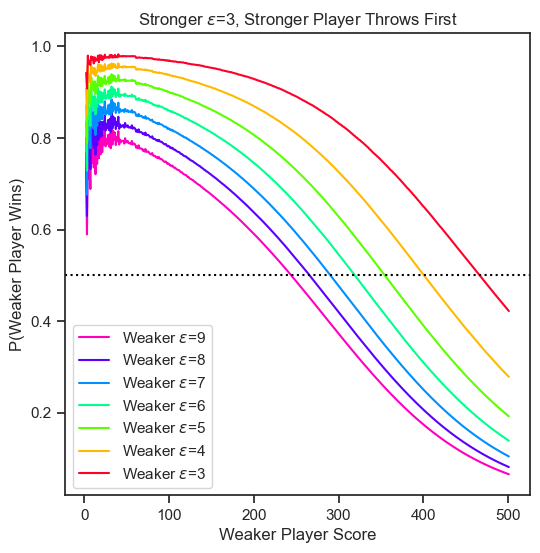

In [64]:
# epsilon_list = [1,2,3,4,5,6,7,8,9]

# Housekeeping 
e_leg = []
vmax=max(epsilon_list)
vmin=min(epsilon_list)
fig = sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks")

# Plot each token line 
for e in reversed(range(len(epsilon_list))):
    epsilon=epsilon_list[e]
    dfew = df_headstart_stronger.loc[df_headstart_stronger.epsilon_weaker==epsilon]
    dfew = dfew[['score_weaker','win_probability_weaker']]    
    dfew = dfew.set_index('score_weaker')
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    e_leg.append(r'Weaker $\epsilon$={}'.format(epsilon))
    fig = plt.plot(dfew,color=color)

fig = plt.title(fr'Stronger $\epsilon$={epsilon}, Stronger Player Throws First')
fig = plt.xlabel(r'Weaker Player Score')
fig = plt.ylabel(r'P(Weaker Player Wins)')
fig = plt.legend(e_leg)

# Plot horizontal line for equal win probabilities 
fig = plt.axhline(0.5,color='black',linestyle='dotted') 

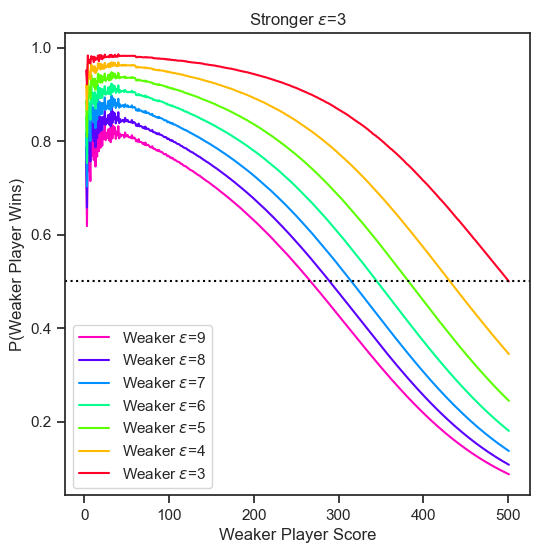

In [65]:
# List of epsilon values
# epsilon_list = [1,2,3,4,5,6,7,8,9]

# Housekeeping 
e_leg = []
vmax=max(epsilon_list)
vmin=min(epsilon_list)
fig = sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks")

# Plot each token line 
for e in reversed(range(len(epsilon_list))):
    epsilon=epsilon_list[e]
    dfew = df_headstart_avg.loc[df_headstart_avg.epsilon_weaker==epsilon]
    dfew = dfew[['score_weaker','win_probability_weaker']]    
    dfew = dfew.set_index('score_weaker')
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    e_leg.append(r'Weaker $\epsilon$={}'.format(epsilon))
    fig = plt.plot(dfew,color=color)

fig = plt.title(fr'Stronger $\epsilon$={epsilon}')
fig = plt.xlabel(r'Weaker Player Score')
fig = plt.ylabel(r'P(Weaker Player Wins)')
fig = plt.legend(e_leg)

# Plot horizontal line for equal win probabilities 
fig = plt.axhline(0.5,color='black',linestyle='dotted') 

In [21]:
import handicap as hc

handicap = hc.Handicap(epsilon_list=epsilon_list)


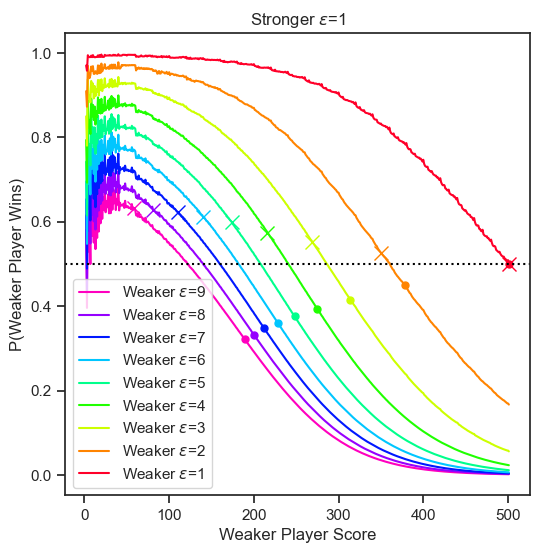

In [22]:


# Housekeeping 
e_leg = []
vmax=max(epsilon_list)
vmin=min(epsilon_list)
fig = sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="ticks")

# Plot each token line 
for e in reversed(range(len(epsilon_list))):
    handicap.get_spot_point_heuristic_handicap(1,2)
    epsilon=epsilon_list[e]
    dfew = df_headstart_avg.loc[df_headstart_avg.epsilon_weaker==epsilon]
    dfew = dfew[['score_weaker','win_probability_weaker']]    
    dfew = dfew.set_index('score_weaker')
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    e_leg.append(r'Weaker $\epsilon$={}'.format(epsilon))
    fig = plt.plot(dfew,color=color)

fig = plt.title(fr'Stronger $\epsilon$={epsilon}')
fig = plt.xlabel(r'Weaker Player Score')
fig = plt.ylabel(r'P(Weaker Player Wins)')
fig = plt.legend(e_leg)

for e in reversed(range(len(epsilon_list))):
    epsilon = epsilon_list[e]
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    dfew = df_headstart_avg.loc[df_headstart_avg.epsilon_weaker==epsilon]
    eh_h = 501 - handicap.get_spot_point_heuristic_handicap(e_stronger,epsilon)
    eh_o = 501 - handicap.get_spot_point_optimal_handicap(e_stronger,epsilon)
    eh_h_v = dfew.loc[dfew.score_weaker==eh_h].win_probability_weaker
    eh_o_v = dfew.loc[dfew.score_weaker==eh_o].win_probability_weaker
    fig = plt.plot(eh_h, eh_h_v, marker="o", markersize=5, color=color)
    fig = plt.plot(eh_o, eh_o_v, marker="x", markersize=10, color=color)



# Plot horizontal line for equal win probabilities 
fig = plt.axhline(0.5,color='black',linestyle='dotted') 

# 3. Heatmap

### 3.1 Stronger-Weaker Split

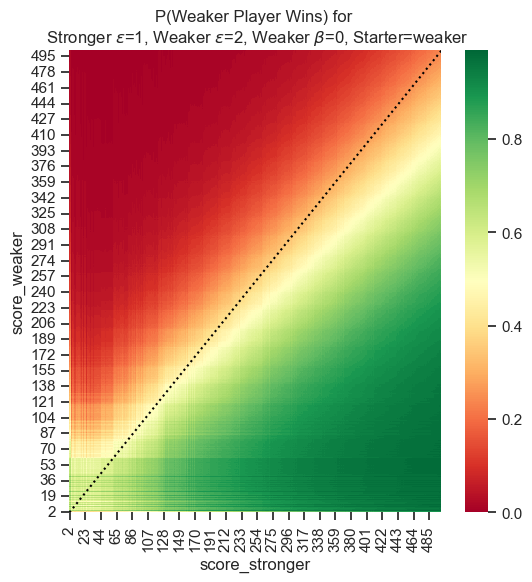

In [84]:
es = 1
ew = 2
cw = 0 
starter = 'weaker' # 'weaker' or 'stronger'

df_heatmap = df.loc[(df.epsilon_stronger==es) & (df.epsilon_weaker==ew) & (df.credits_weaker==cw) & (df.current_turn==starter)]

df_heatmap = df_heatmap.pivot(index='score_weaker',columns='score_stronger',values='win_probability_weaker')
df_heatmap = df_heatmap.round(2)

fig, ax = plt.subplots(1, 1)

title = f'P(Weaker Player Wins) for \n Stronger $\epsilon$={es}, Weaker $\epsilon$={ew}, Weaker $\\beta$={cw}, Starter={starter}'
img = plt.title(title)
img = sns.heatmap(df_heatmap,cmap='RdYlGn')
img = ax.invert_yaxis() 
img = ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='black',linestyle='dotted')


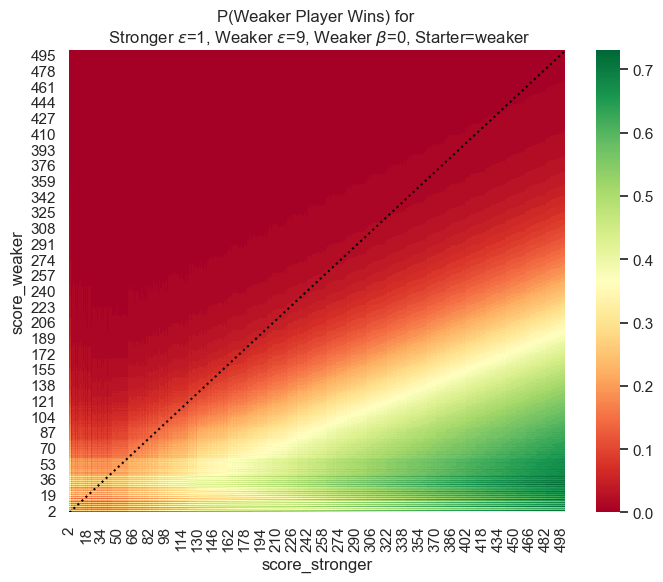

In [91]:
es = 1
ew = 9
cw = 0 
starter = 'weaker' # 'weaker' or 'stronger'

df_heatmap = df.loc[(df.epsilon_stronger==es) & (df.epsilon_weaker==ew) & (df.credits_weaker==cw) & (df.current_turn==starter)]

df_heatmap = df_heatmap.pivot(index='score_weaker',columns='score_stronger',values='win_probability_weaker')
df_heatmap = df_heatmap.round(2)

fig, ax = plt.subplots(1, 1)

title = f'P(Weaker Player Wins) for \n Stronger $\epsilon$={es}, Weaker $\epsilon$={ew}, Weaker $\\beta$={cw}, Starter={starter}'
img = plt.title(title)
img = sns.heatmap(df_heatmap,cmap='RdYlGn')
img = ax.invert_yaxis() 
img = ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='black',linestyle='dotted')

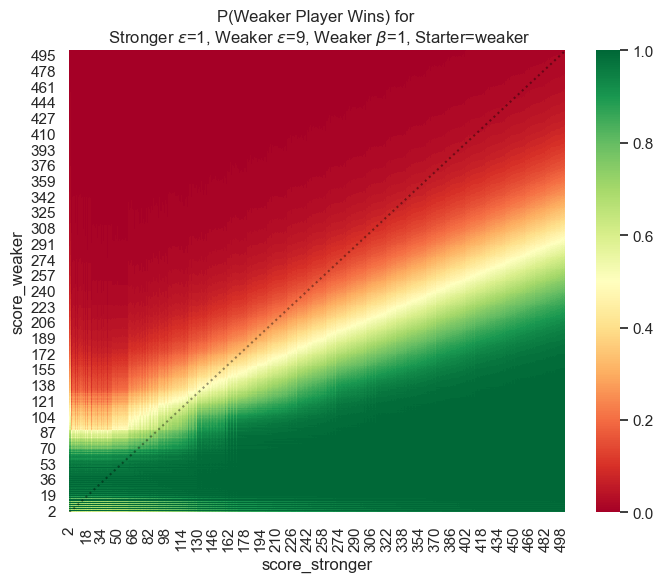

In [89]:
es = 1
ew = 9
cw = 1
starter = 'weaker' # 'weaker' or 'stronger'

df_heatmap = df.loc[(df.epsilon_stronger==es) & (df.epsilon_weaker==ew) & (df.credits_weaker==cw) & (df.current_turn==starter)]

df_heatmap = df_heatmap.pivot(index='score_weaker',columns='score_stronger',values='win_probability_weaker')
df_heatmap = df_heatmap.round(2)

fig, ax = plt.subplots(1, 1)

title = f'P(Weaker Player Wins) for \n Stronger $\epsilon$={es}, Weaker $\epsilon$={ew}, Weaker $\\beta$={cw}, Starter={starter}'
img = plt.title(title)
img = sns.heatmap(df_heatmap,cmap='RdYlGn')
img = ax.invert_yaxis() 
img = ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='black',linestyle='dotted',alpha=0.4)

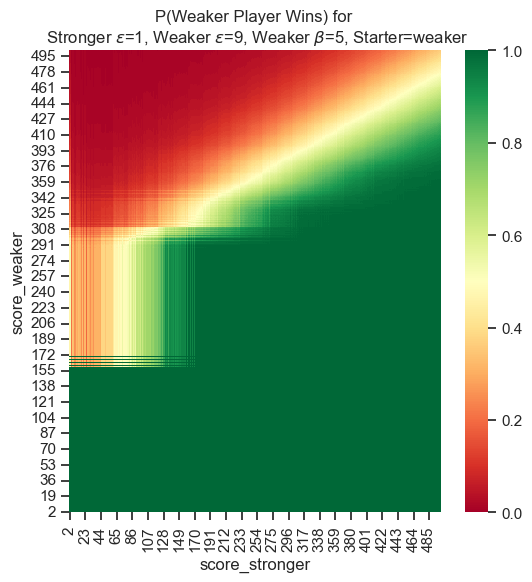

In [26]:
es = 1
ew = 9
cw = 5
starter = 'weaker' # 'weaker' or 'stronger'

df_heatmap = df.loc[(df.epsilon_stronger==es) & (df.epsilon_weaker==ew) & (df.credits_weaker==cw) & (df.current_turn==starter)]

df_heatmap = df_heatmap.pivot(index='score_weaker',columns='score_stronger',values='win_probability_weaker')
df_heatmap = df_heatmap.round(2)

fig, ax = plt.subplots(1, 1)

title = f'P(Weaker Player Wins) for \n Stronger $\epsilon$={es}, Weaker $\epsilon$={ew}, Weaker $\\beta$={cw}, Starter={starter}'
img = plt.title(title)
img = sns.heatmap(df_heatmap,cmap='RdYlGn')
img = ax.invert_yaxis() 


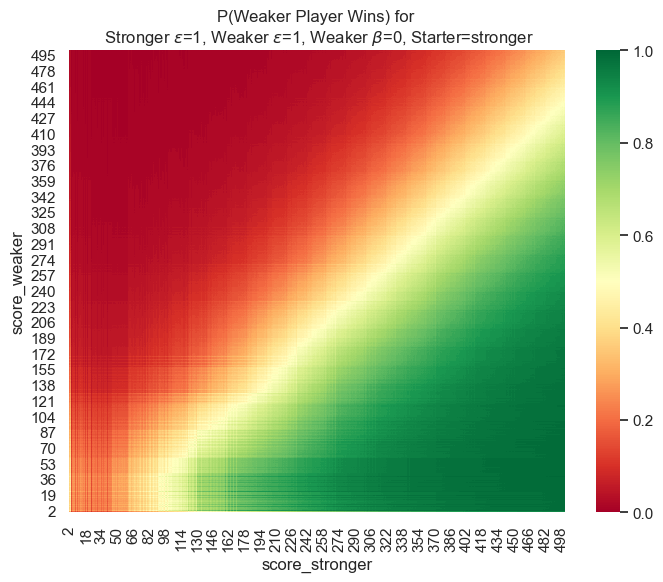

In [31]:
fig = sns.set(rc={'figure.figsize':(8,6)})

es = 1
ew = 1
cw = 0
starter = 'stronger' # 'weaker' or 'stronger'

df_heatmap = df.loc[(df.epsilon_stronger==es) & (df.epsilon_weaker==ew) & (df.credits_weaker==cw) & (df.current_turn==starter)]

df_heatmap = df_heatmap.pivot(index='score_weaker',columns='score_stronger',values='win_probability_weaker')
df_heatmap = df_heatmap.round(2)

fig, ax = plt.subplots(1, 1)

title = f'P(Weaker Player Wins) for \n Stronger $\epsilon$={es}, Weaker $\epsilon$={ew}, Weaker $\\beta$={cw}, Starter={starter}'
img = plt.title(title)
img = sns.heatmap(df_heatmap,cmap='RdYlGn')
img = ax.invert_yaxis() 


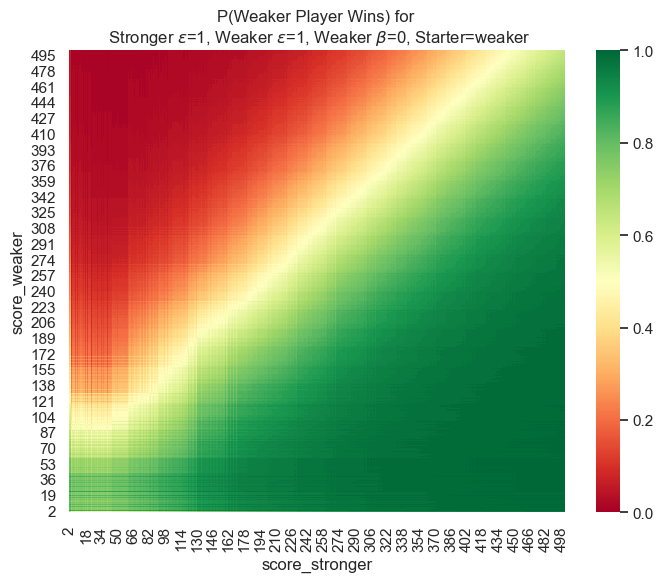

In [29]:
fig = sns.set(rc={'figure.figsize':(8,6)})

es = 1
ew = 1
cw = 0
starter = 'weaker' # 'weaker' or 'stronger'

df_heatmap = df.loc[(df.epsilon_stronger==es) & (df.epsilon_weaker==ew) & (df.credits_weaker==cw) & (df.current_turn==starter)]

df_heatmap = df_heatmap.pivot(index='score_weaker',columns='score_stronger',values='win_probability_weaker')
df_heatmap = df_heatmap.round(2)

fig, ax = plt.subplots(1, 1)

title = f'P(Weaker Player Wins) for \n Stronger $\epsilon$={es}, Weaker $\epsilon$={ew}, Weaker $\\beta$={cw}, Starter={starter}'
img = plt.title(title)
img = sns.heatmap(df_heatmap,cmap='RdYlGn')
img = ax.invert_yaxis() 

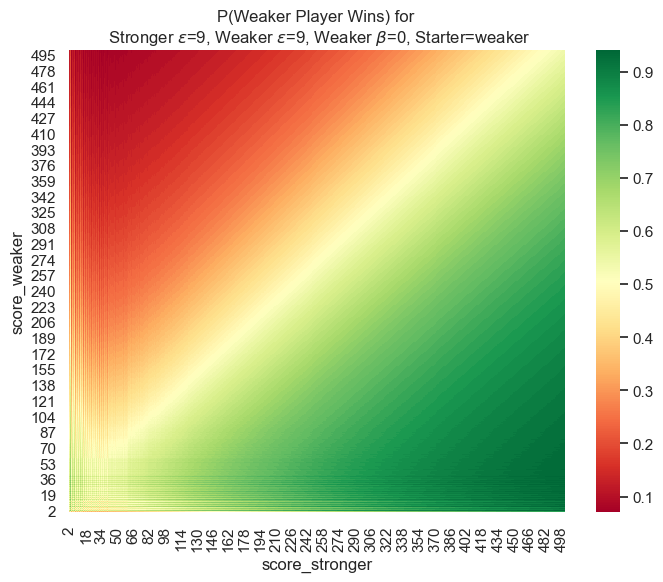

In [33]:
es = 9
ew = 9
cw = 0
starter = 'weaker' # 'weaker' or 'stronger'

df_heatmap = df.loc[(df.epsilon_stronger==es) & (df.epsilon_weaker==ew) & (df.credits_weaker==cw) & (df.current_turn==starter)]

df_heatmap = df_heatmap.pivot(index='score_weaker',columns='score_stronger',values='win_probability_weaker')
df_heatmap = df_heatmap.round(2)

fig, ax = plt.subplots(1, 1)

title = f'P(Weaker Player Wins) for \n Stronger $\epsilon$={es}, Weaker $\epsilon$={ew}, Weaker $\\beta$={cw}, Starter={starter}'
img = plt.title(title)
img = sns.heatmap(df_heatmap,cmap='RdYlGn')
img = ax.invert_yaxis() 

### 3.2 Averaged

/var/folders/jj/jcq76kp53_zchkx8b5cvhdsh0000gn/T/ipykernel_1026/34062721.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_heatmap = df_heatmap.groupby(['score_weaker','score_stronger']).mean()


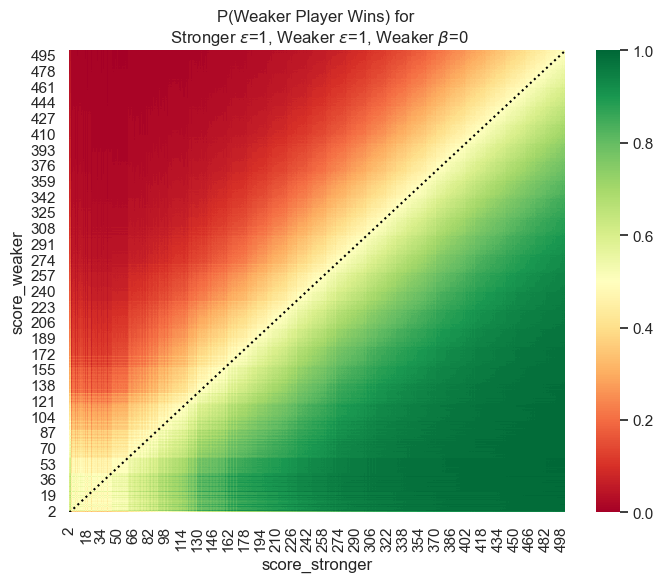

In [184]:
fig = sns.set(rc={'figure.figsize':(8,6)})

es = 1
ew = 1
cw = 0
starter = 'stronger' # 'weaker' or 'stronger'

df_heatmap = df.loc[(df.epsilon_stronger==es) & (df.epsilon_weaker==ew) & (df.credits_weaker==cw)]
df_heatmap = df_heatmap.groupby(['score_weaker','score_stronger']).mean()
df_heatmap = df_heatmap.reset_index()
df_heatmap = df_heatmap.pivot(index='score_weaker',columns='score_stronger',values='win_probability_weaker')
df_heatmap = df_heatmap.round(2)

fig, ax = plt.subplots(1, 1)

title = f'P(Weaker Player Wins) for \n Stronger $\epsilon$={es}, Weaker $\epsilon$={ew}, Weaker $\\beta$={cw}'
img = plt.title(title)
img = sns.heatmap(df_heatmap,cmap='RdYlGn')
img = ax.invert_yaxis() 
img = ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='black',linestyle='dotted')

/var/folders/jj/jcq76kp53_zchkx8b5cvhdsh0000gn/T/ipykernel_1026/817880779.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_heatmap = df_heatmap.groupby(['score_weaker','score_stronger']).mean()


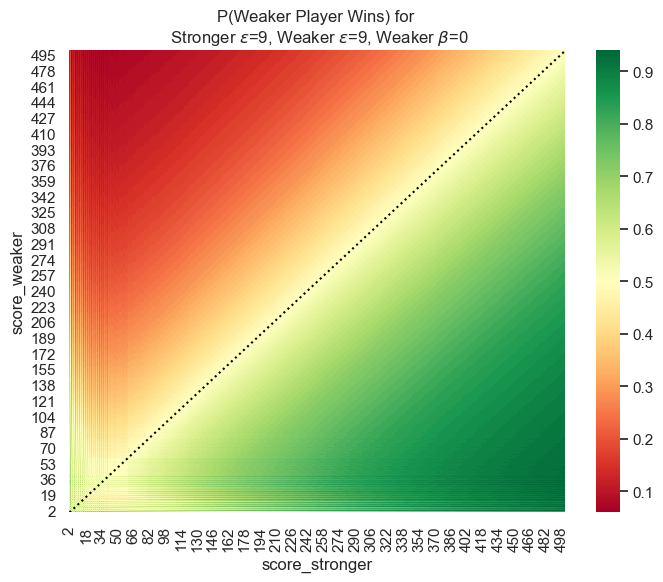

In [182]:
fig = sns.set(rc={'figure.figsize':(8,6)})

es = 9
ew = 9
cw = 0
starter = 'stronger' # 'weaker' or 'stronger'

df_heatmap = df.loc[(df.epsilon_stronger==es) & (df.epsilon_weaker==ew) & (df.credits_weaker==cw)]
df_heatmap = df_heatmap.groupby(['score_weaker','score_stronger']).mean()
df_heatmap = df_heatmap.reset_index()
df_heatmap = df_heatmap.pivot(index='score_weaker',columns='score_stronger',values='win_probability_weaker')
df_heatmap = df_heatmap.round(2)

fig, ax = plt.subplots(1, 1)

title = f'P(Weaker Player Wins) for \n Stronger $\epsilon$={es}, Weaker $\epsilon$={ew}, Weaker $\\beta$={cw}'
img = plt.title(title)
img = sns.heatmap(df_heatmap,cmap='RdYlGn')
img = ax.invert_yaxis() 
img = ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='black',linestyle='dotted')

/var/folders/jj/jcq76kp53_zchkx8b5cvhdsh0000gn/T/ipykernel_1026/41755628.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_heatmap = df_heatmap.groupby(['score_weaker','score_stronger']).mean()


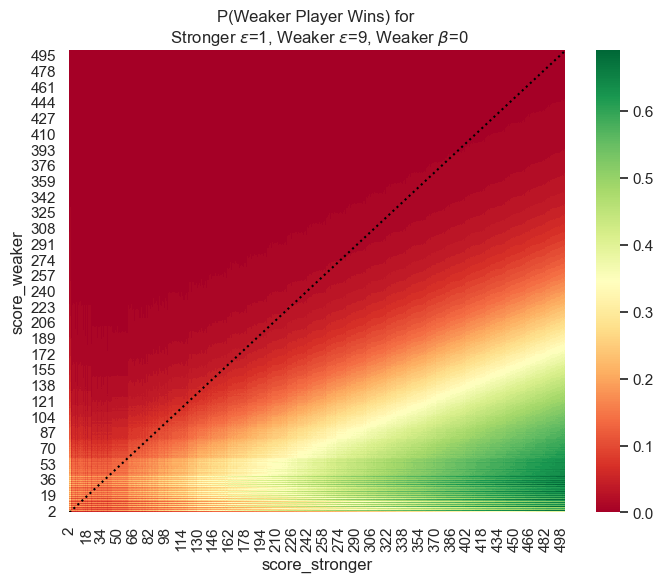

In [183]:
fig = sns.set(rc={'figure.figsize':(8,6)})

es = 1
ew = 9
cw = 0
starter = 'stronger' # 'weaker' or 'stronger'

df_heatmap = df.loc[(df.epsilon_stronger==es) & (df.epsilon_weaker==ew) & (df.credits_weaker==cw)]
df_heatmap = df_heatmap.groupby(['score_weaker','score_stronger']).mean()
df_heatmap = df_heatmap.reset_index()
df_heatmap = df_heatmap.pivot(index='score_weaker',columns='score_stronger',values='win_probability_weaker')
df_heatmap = df_heatmap.round(2)

fig, ax = plt.subplots(1, 1)

title = f'P(Weaker Player Wins) for \n Stronger $\epsilon$={es}, Weaker $\epsilon$={ew}, Weaker $\\beta$={cw}'
img = plt.title(title)
img = sns.heatmap(df_heatmap,cmap='RdYlGn')
img = ax.invert_yaxis() 
img = ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='black',linestyle='dotted')

/var/folders/jj/jcq76kp53_zchkx8b5cvhdsh0000gn/T/ipykernel_1026/3691354313.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_heatmap = df_heatmap.groupby(['score_weaker','score_stronger']).mean()


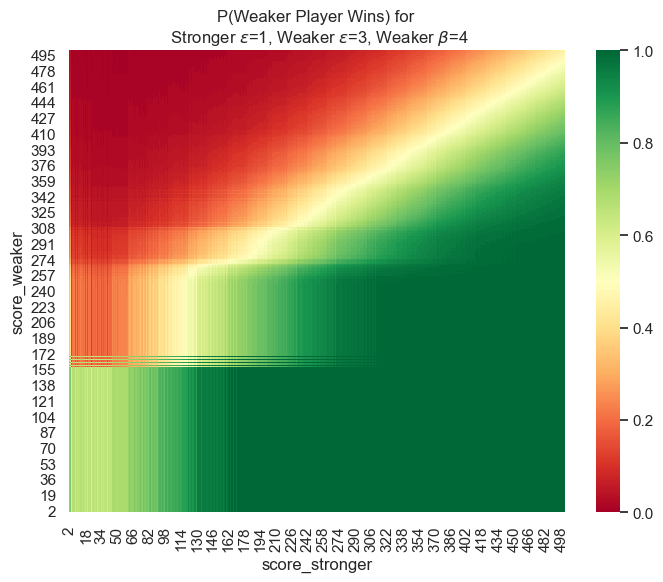

In [40]:
fig = sns.set(rc={'figure.figsize':(8,6)})

es = 1
ew = 3
cw = 4
starter = 'stronger' # 'weaker' or 'stronger'

df_heatmap = df.loc[(df.epsilon_stronger==es) & (df.epsilon_weaker==ew) & (df.credits_weaker==cw)]
df_heatmap = df_heatmap.groupby(['score_weaker','score_stronger']).mean()
df_heatmap = df_heatmap.reset_index()
df_heatmap = df_heatmap.pivot(index='score_weaker',columns='score_stronger',values='win_probability_weaker')
df_heatmap = df_heatmap.round(2)

fig, ax = plt.subplots(1, 1)

title = f'P(Weaker Player Wins) for \n Stronger $\epsilon$={es}, Weaker $\epsilon$={ew}, Weaker $\\beta$={cw}'
img = plt.title(title)
img = sns.heatmap(df_heatmap,cmap='RdYlGn')
img = ax.invert_yaxis() 

/var/folders/jj/jcq76kp53_zchkx8b5cvhdsh0000gn/T/ipykernel_1026/3185361087.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_heatmap = df_heatmap.groupby(['score_weaker','score_stronger']).mean()


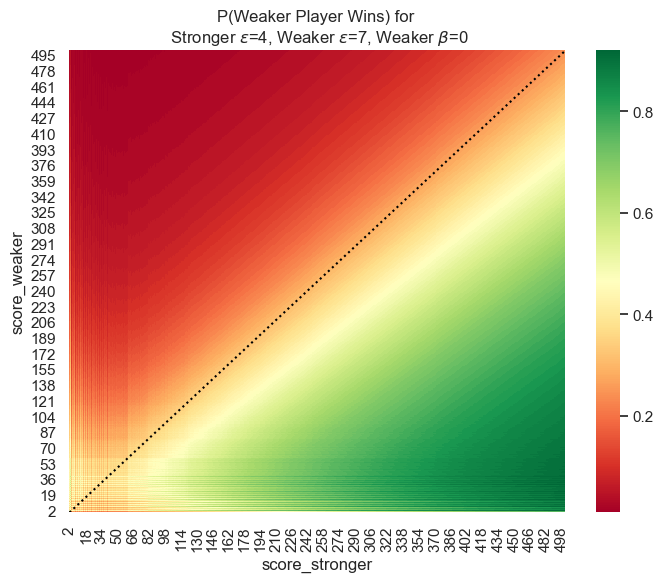

In [92]:
fig = sns.set(rc={'figure.figsize':(8,6)})

es = 4
ew = 7
cw = 0
starter = 'stronger' # 'weaker' or 'stronger'

df_heatmap = df.loc[(df.epsilon_stronger==es) & (df.epsilon_weaker==ew) & (df.credits_weaker==cw)]
df_heatmap = df_heatmap.groupby(['score_weaker','score_stronger']).mean()
df_heatmap = df_heatmap.reset_index()
df_heatmap = df_heatmap.pivot(index='score_weaker',columns='score_stronger',values='win_probability_weaker')
df_heatmap = df_heatmap.round(2)

fig, ax = plt.subplots(1, 1)

title = f'P(Weaker Player Wins) for \n Stronger $\epsilon$={es}, Weaker $\epsilon$={ew}, Weaker $\\beta$={cw}'
img = plt.title(title)
img = sns.heatmap(df_heatmap,cmap='RdYlGn')
img = ax.invert_yaxis() 
img = ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='black',linestyle='dotted')

/var/folders/jj/jcq76kp53_zchkx8b5cvhdsh0000gn/T/ipykernel_1026/252037436.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_heatmap = df_heatmap.groupby(['score_weaker','score_stronger']).mean()


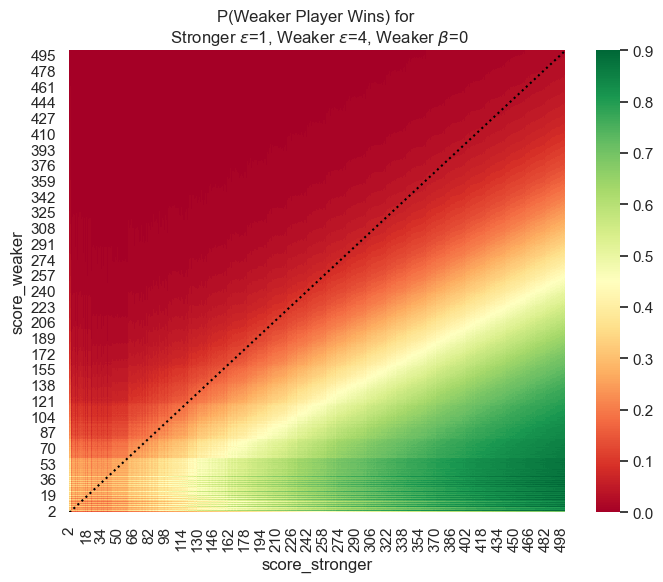

In [93]:
fig = sns.set(rc={'figure.figsize':(8,6)})

es = 1
ew = 4
cw = 0
starter = 'stronger' # 'weaker' or 'stronger'

df_heatmap = df.loc[(df.epsilon_stronger==es) & (df.epsilon_weaker==ew) & (df.credits_weaker==cw)]
df_heatmap = df_heatmap.groupby(['score_weaker','score_stronger']).mean()
df_heatmap = df_heatmap.reset_index()
df_heatmap = df_heatmap.pivot(index='score_weaker',columns='score_stronger',values='win_probability_weaker')
df_heatmap = df_heatmap.round(2)

fig, ax = plt.subplots(1, 1)

title = f'P(Weaker Player Wins) for \n Stronger $\epsilon$={es}, Weaker $\epsilon$={ew}, Weaker $\\beta$={cw}'
img = plt.title(title)
img = sns.heatmap(df_heatmap,cmap='RdYlGn')
img = ax.invert_yaxis() 
img = ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='black',linestyle='dotted')